In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: >

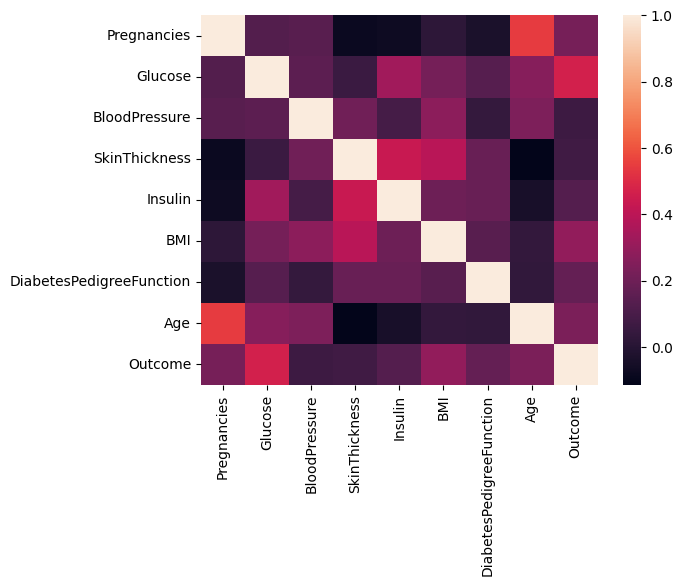

In [3]:
sns.heatmap(data=df.corr())

In [4]:
outliers = []

for col in df.columns:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    outliers.extend(column_outliers)

clean_df_iqr = df.drop(list(set(outliers))).reset_index(drop=True)
clean_df_iqr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
634,10,101,76,48,180,32.9,0.171,63,0
635,2,122,70,27,0,36.8,0.340,27,0
636,5,121,72,23,112,26.2,0.245,30,0
637,1,126,60,0,0,30.1,0.349,47,1


In [5]:
outliers = []
threshold = 3

z_scores = zscore(df)

outliers = (abs(z_scores) > threshold).any(axis=1)

clean_df_zscore = df[~outliers].reset_index(drop=True)
clean_df_zscore

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
683,10,101,76,48,180,32.9,0.171,63,0
684,2,122,70,27,0,36.8,0.340,27,0
685,5,121,72,23,112,26.2,0.245,30,0
686,1,126,60,0,0,30.1,0.349,47,1


In [6]:
df_scaled, df_iqr_scaled, df_zscore_scaled = [

    pd.DataFrame(

        data=StandardScaler().fit_transform(data.drop('Outcome', axis=1)),
        columns=data.columns[:-1]

    ).join(
        pd.DataFrame(
            data=data['Outcome'],
            columns=['Outcome']
        )
    )

    for data in [

        df, clean_df_iqr, clean_df_zscore
    ]
]

In [7]:
data = [
    df,
    df_scaled,
    clean_df_iqr,
    df_iqr_scaled,
    clean_df_zscore,
    df_zscore_scaled
]
names = [
    'df',
    'df_scaled',
    'clean_df_iqr',
    'df_iqr_scaled',
    'clean_df_zscore',
    'df_zscore_scaled'
]

data_dict = dict(zip(names, data))

In [8]:
values = []

for name, df in data_dict.items():

    X = df.drop('Outcome', axis=1)
    y = df['Outcome']

    X_train, X_test, y_train, y_test = train_test_split(

        X,
        y,
        test_size=0.25,
        random_state=42,
        shuffle=True
    )

    for criterion in ['entropy', 'gini']:

        i = 1

        while True:

            model = DecisionTreeClassifier(
                criterion=criterion,
                splitter='best',
                max_depth=i,
                random_state=42
            )

            model.fit(X_train, y_train)

            y_pred_entropy_train = model.predict(X_train)
            y_pred_entropy_test = model.predict(X_test)

            depth = model.get_depth()
            train = accuracy_score(y_train, y_pred_entropy_train) * 100
            test = accuracy_score(y_test, y_pred_entropy_test) * 100

            message = f"{name} - {criterion} - Depth: {depth} -> Train: {train} - Test: {test}"
            print(f"{message} - {i} ", end='\r')

            i += 1

            if values and values[-1][2] == depth: break
            values.append((message, model, depth, train, test))

    print(' '*1000, end='\r')

print()
print(values)

In [9]:
best = max(values, key=lambda x: x[-1])

best_message, best_model, _, _, _ = best

for i in values:
    if i[-1] == best[-1]:
        print(i)

('clean_df_iqr - entropy - Depth: 1 -> Train: 76.61795407098121 - Test: 77.5', DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42), 1, 76.61795407098121, 77.5)
('clean_df_iqr - entropy - Depth: 4 -> Train: 80.58455114822547 - Test: 77.5', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42), 4, 80.58455114822547, 77.5)
('clean_df_iqr - gini - Depth: 1 -> Train: 76.61795407098121 - Test: 77.5', DecisionTreeClassifier(max_depth=1, random_state=42), 1, 76.61795407098121, 77.5)
('clean_df_iqr - gini - Depth: 6 -> Train: 86.43006263048017 - Test: 77.5', DecisionTreeClassifier(max_depth=6, random_state=42), 6, 86.43006263048017, 77.5)
('df_iqr_scaled - entropy - Depth: 1 -> Train: 76.61795407098121 - Test: 77.5', DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42), 1, 76.61795407098121, 77.5)
('df_iqr_scaled - entropy - Depth: 4 -> Train: 80.58455114822547 - Test: 77.5', DecisionTreeClassifier(criterion='entropy', max_depth=4, 

In [10]:
df_values = pd.DataFrame(values, columns=['Preprocessing', 'Model', 'Depth', 'Train Accuracy', 'Test Accuracy']).drop('Model', axis=1)
df_sorted = df_values.sort_values(by='Test Accuracy', ascending=False)

df_sorted.to_csv('decision_tree_results.csv', index=False)

print(df_sorted.to_markdown(index=False))

| Preprocessing                                                                                |   Depth |   Train Accuracy |   Test Accuracy |
|:---------------------------------------------------------------------------------------------|--------:|-----------------:|----------------:|
| df_iqr_scaled - entropy - Depth: 1 -> Train: 76.61795407098121 - Test: 77.5                  |       1 |          76.618  |         77.5    |
| clean_df_iqr - gini - Depth: 6 -> Train: 86.43006263048017 - Test: 77.5                      |       6 |          86.4301 |         77.5    |
| clean_df_iqr - gini - Depth: 1 -> Train: 76.61795407098121 - Test: 77.5                      |       1 |          76.618  |         77.5    |
| df_iqr_scaled - entropy - Depth: 4 -> Train: 80.58455114822547 - Test: 77.5                  |       4 |          80.5846 |         77.5    |
| clean_df_iqr - entropy - Depth: 4 -> Train: 80.58455114822547 - Test: 77.5                   |       4 |          80.5846 |         77

In [11]:
values = []

for j in range(1, 9):

    for name, df in data_dict.items():

        X = df.drop('Outcome', axis=1)
        X = PCA(n_components=j).fit_transform(X)
        y = df['Outcome']

        X_train, X_test, y_train, y_test = train_test_split(

            X,
            y,
            test_size=0.25,
            random_state=42,
            shuffle=True
        )

        for criterion in ['entropy', 'gini']:

            i = 1

            while True:

                model = DecisionTreeClassifier(
                    criterion=criterion,
                    splitter='best',
                    max_depth=i,
                    random_state=42
                )

                model.fit(X_train, y_train)

                y_pred_entropy_train = model.predict(X_train)
                y_pred_entropy_test = model.predict(X_test)

                depth = model.get_depth()
                train = accuracy_score(y_train, y_pred_entropy_train) * 100
                test = accuracy_score(y_test, y_pred_entropy_test) * 100

                message = f"{name} - {criterion} - {depth} pca:{j} -> Train: {train} - Test: {test}"
                print(f"{message} - {i} ", end='\r')

                i += 1

                if values and values[-1][2] == depth: break
                values.append((message, model, depth, j, train, test))

        print(' '*1000, end='\r')

print()
print(values)

In [12]:
best = max(values, key=lambda x: x[-1])

best_message, best_model, pca, _, _, _ = best

for i in values:
    if i[-1] == best[-1]:
        print(i)

('clean_df_iqr - entropy - 1 pca:2 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42), 1, 2, 77.8705636743215, 76.25)
('clean_df_iqr - entropy - 2 pca:2 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42), 2, 2, 77.8705636743215, 76.25)
('clean_df_iqr - gini - 1 pca:2 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(max_depth=1, random_state=42), 1, 2, 77.8705636743215, 76.25)
('clean_df_iqr - gini - 2 pca:2 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(max_depth=2, random_state=42), 2, 2, 77.8705636743215, 76.25)
('clean_df_iqr - entropy - 1 pca:3 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42), 1, 3, 77.8705636743215, 76.25)
('clean_df_iqr - entropy - 2 pca:3 -> Train: 77.8705636743215 - Test: 76.25', DecisionTreeClassifier(criterion='entropy', max_de

In [13]:
df_values = pd.DataFrame(values, columns=['Preprocessing', 'Model', 'Depth', 'n_components', 'Train Accuracy', 'Test Accuracy']).drop('Model', axis=1)
df_sorted = df_values.sort_values(by='Test Accuracy', ascending=False)

df_sorted.to_csv('decision_tree_results_pca.csv', index=False)

print(df_sorted.to_markdown(index=False))

| Preprocessing                                                                                |   Depth |   n_components |   Train Accuracy |   Test Accuracy |
|:---------------------------------------------------------------------------------------------|--------:|---------------:|-----------------:|----------------:|
| clean_df_iqr - entropy - 2 pca:2 -> Train: 77.8705636743215 - Test: 76.25                    |       2 |              2 |          77.8706 |         76.25   |
| clean_df_iqr - entropy - 3 pca:4 -> Train: 78.49686847599166 - Test: 76.25                   |       3 |              4 |          78.4969 |         76.25   |
| clean_df_iqr - entropy - 1 pca:3 -> Train: 77.8705636743215 - Test: 76.25                    |       1 |              3 |          77.8706 |         76.25   |
| clean_df_iqr - entropy - 2 pca:3 -> Train: 77.8705636743215 - Test: 76.25                    |       2 |              3 |          77.8706 |         76.25   |
| clean_df_iqr - entropy - 3 pca:3

#### Best: 77.5

In [14]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],  # No changes needed
    "splitter": ["best", "random"],  # No changes needed
    "max_depth": np.linspace(1, 50, 10).astype(int).tolist(),  # Reduced to 10 values
    "min_samples_split": np.linspace(2, 50, 10).astype(int).tolist(),  # Reduced to 10 values
    "min_samples_leaf": np.linspace(1, 20, 10).astype(int).tolist(),  # Reduced to 10 values
    "max_features": [None, "sqrt", "log2"],  # No changes needed
    "min_weight_fraction_leaf": np.linspace(0, 0.5, 5).tolist(),  # Reduced to 5 values
    "max_leaf_nodes": np.linspace(2, 50, 10).astype(int).tolist(),  # Reduced to 10 values
    "random_state": [42],  # Fixed to a single random seed for reproducibility
    "ccp_alpha": np.linspace(0, 0.1, 5).tolist(),  # Reduced to 5 values
}

# param_grid = {
#     "criterion": ["gini", "entropy", "log_loss"],
#     "splitter": ["best", "random"],
#     "max_depth": np.linspace(1, 50, 5).astype(int).tolist(),  # 5 values instead of 100
#     "min_samples_split": np.linspace(2, 100, 5).astype(int).tolist(),  # 5 values instead of 700
#     "min_samples_leaf": np.linspace(1, 50, 5).astype(int).tolist(),  # 5 values instead of 700
#     "max_features": [None, "sqrt", "log2"],
#     "ccp_alpha": np.linspace(0.001, 0.1, 5).tolist(),  # Reduced range
# }

In [15]:
model = DecisionTreeClassifier()

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    verbose=4,
    cv=10
)

In [16]:
X = clean_df_iqr.drop("Outcome", axis=1)
y = clean_df_iqr['Outcome']

X_train, X_test, y_train, y_test = train_test_split(

        X,
        y,
        test_size=0.25,
        random_state=42,
        shuffle=True
    )

In [17]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 4500000 candidates, totalling 45000000 fits


KeyboardInterrupt: 

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

#### Best Parameters: {'ccp_alpha': 0.025750000000000002, 'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 75, 'splitter': 'random'}
Best Score: 0.7765957446808511